# Introduction to Probabilistic Graphical Models
## Practical Session 1
### Author: Xiang Yu, Email: shawnxiangyu@yahoo.com

In [105]:
%matplotlib inline
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
import networkx as nx
import pyparsing
from IPython.display import Math
import copy

import warnings
warnings.filterwarnings("ignore")

### Question 0

We often need to compute    
$$
s= log\sum_{i=1}^I \exp(v_i)
$$
where each $v_i < 0$ and $|v_i|$ is very large. The direct calculation of $s$ may not be numerically stable. Therefore, we propose the calculation as the following: 
$$
  V_{max} = \max_{i} v_i 
$$
Then, 
\begin{align}
s &= log\sum_{i=1}^I \exp(v_i) \\
 & = log\sum_{i=1}^I \exp(v_i- V_{max} + V_{max}) \\
 & = log\sum_{i=1}^I \exp(v_i- V_{max}) * exp(V_{max}) \\
 & = V_{max} + log\sum_{i=1}^I \exp(v_i- V_{max})
\end{align}

We define function L for later calculation
$$
L(v_i) =  V_{max} + log\sum_{i=1}^I \exp(v_i- V_{max})
$$
    
    

In [7]:
####Q0
def naive_logsum_exp(xs):     
    return np.log(np.sum(np.exp(xs)))

def stable_logsumexp(xs): 
    max_xs = np.max(xs)
    nr_xs = len(xs)
    vi_vmax = xs - max_xs   
    return max_xs + np.log(np.sum(np.exp(vi_vmax)))

# calculate the result for q0:
xs = [-1234, -1235]
naive_s = naive_logsum_exp(xs) 
stable_s = stable_logsumexp(xs)

print("Naivie and stable solution are: ", naive_s, ',', stable_s)

Naivie and stable solution are:  -inf , -1233.6867383124818


### Q0: Explain why it should work: 
When $v_i < 0$ and $|v_i|$ is very large, $\exp(v_i)$ will be extremly small and could easily be over the machine precision, the machine may think then the returned value will be zero,  and $log(0)$ will return infinity. 

With the stable method, $v_i- V_{max}$ will always be smaller or equal to zero and one element of $v_i- V_{max}$ will be zero, leading to $log\sum_{i=1}^I \exp(v_i- V_{max})$ strictly positive, and when plusing a constant $V_{max}$, the result will be numerically stable. 

### Q1 

####   Q1.1
The position domain will be $PD = \{1, 2, ..., N\}$. The action domain will be $AD = \{0, 1\}$, here $0$ means the robot stays where it is and $1$ means the robot moves to the next point in the counter-clock direction. 
The variables are as follows: 

- $x_k$, the actual position at each step, where $x_k \in PD$
- $y_k$, the observed position at each step, where $y_k \in PD$
- $a_k$, the action taken at each step, where $a_k \in AD$


The generative model is as follows: 

$$\large p(x_{1:k} , y_{1:k}) = \{\pi_{i=2}^{k}p(y_i|x_i)p(x_i|x_{i-1})\}p(x_1)p(y_1|x_1)$$



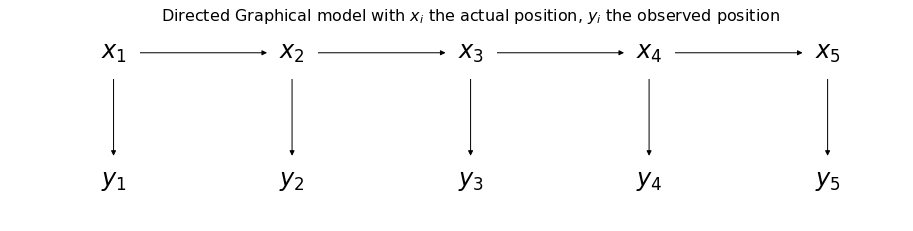

In [8]:
### draw the accociated directed graphical model
# This section code coming from : https://github.com/atcemgil/notes/blob/master/HiddenMarkovModel.ipynb
def makeDBN(inter, intra, T, labels):
    """Unfold a graph for T time slices"""
    N = max(max([i for i,j in inter]),max([j for i,j in inter]))+1

    G = np.zeros((N*T,N*T))
    pos = []
    all_labels = []
    for n in range(N):
        pos.append((0,-n))
        all_labels.append('$'+labels[n]+'_{'+str(0+1)+"}"+'$')
        
    for e in inter:
        s,d = e
        G[s,d] = 1

    for t in range(1,T):
        for n in range(N):
            pos.append((t,-n))
            all_labels.append('$'+labels[n]+'_{'+str(t+1)+"}"+'$')

        for e in inter:
            s,d = e
            s = s + N*t
            d = d + N*t
            G[s,d] = 1
        
        for e in intra:
            s,d = e
            s = s + N*(t-1)
            d = d + N*t
            G[s,d] = 1
    return G,pos,all_labels


np.set_printoptions(precision=5, suppress=True)
inter = [(0,1)]
intra = [(0,0)]
variable_names = ["x", "y"] 
T = 5
A, pos, label_list = makeDBN(inter, intra, T, variable_names)

G = nx.DiGraph(A)
labels = {i: s for i,s in enumerate(label_list)}
plt.figure(figsize=(12,2.5))
nx.draw(G, pos, node_color="white", node_size=2500, labels=labels, font_size=24, arrows=True)
plt.title(r'Directed Graphical model with $x_i$ the actual position, $y_i$ the observed position', fontsize=16)
plt.show()

####   Q1.2

The transition model is: $x_k \sim p(x_k | x_{k-1})$ and the observation model is: 
$y_k \sim p(y_k | x_k)$. 

$$
p(x_1 = i) = \frac{1}{N} \\
p(y_1 = i | x_1 = i) = w  + \frac{1}{N} *(1-w)\\ 
p(y_1 = i  | x_1 = j) = \frac{1}{N} *(1-w), where \ i \neq j\\
p(x_2 = i | x_1 = i) = \epsilon \\
p(x_2 = j | x_1 = i) = 1 - \epsilon \\
$$


Where  $j = mod(i - 1 + N, N)$,i.e. a counter-clock direction position next to $i$   
$$
p(x_2 = k | x_1 = i) = 0
$$
where $k \neq i $ and $ k \neq j $, with $j$ the same definition as above.
$$
p(y_2 = i | x_k = i) =  w + \frac{1-w}{N} \\
...
$$



$$
p(x_k = i | x_{k-1} = i) = \epsilon \\
p(x_k = j | x_{k-1} = i) = 1 - \epsilon, j \ counter-clock \  position \ next\  to \  i\\
p(x_k = k | x_{k-1} = i) = 0, k \neq i \ and \  k \neq j \\
p(y_k = i | x_k = i) = w + \frac{1-w}{N} \\
p(y_k = i  | x_k = j) = \frac{1}{N} *(1-w), where \ i \neq j
$$



The transition model written in a matrix form, with  $j = mod(i - 1 + N, N)$, i.e. a counter-clock direction position next to $i$ ; when i = 1, j will be equal to N: 
$$p(x_{k+1}|x_k=i)= \begin{pmatrix}
 0   \\
...  \\
1 - \epsilon  \\
\epsilon  \\
...  \\
0 
\end{pmatrix}, \ with\ \  each\  row \  corresponding\ to \ x_{k+1} = \  
\begin{pmatrix}
 1   \\
...  \\
j \\
i  \\
...  \\
N 
\end{pmatrix}  $$


The observation model in matrix form: 
$$p(y_{k}|x_k=i)= \begin{pmatrix}
 \frac{1-w}{N}    \\
...  \\
 \frac{1-w}{N}  \\
w +  \frac{1-w}{N}  \\
 \frac{1-w}{N}  \\
...  \\
 \frac{1-w}{N} 
\end{pmatrix}, \ with\ \  each\  row \  corresponding\ to \ y_{k} = \  
\begin{pmatrix}
 1   \\
...  \\
i-1 \\
i  \\
i+1 \\
...  \\
N 
\end{pmatrix}  $$

####   Q1.3

We define: 
$$
\large p(x_k, y_{1:k}) =  \alpha_{k|k}(x_k) \\
\large p(x_k, y_{1:k-1}) = \alpha_{k|k-1}(x_k) \\
\large p(y_{k:N}|x_k) = \beta_{k|k}(x_k) \\
\large p(y_{k+1:N}|x_k) = \beta_{k|k+1}(x_k) \\
\large \beta_{N|N+1}(x_N) = 1
$$
Where $N$ is the total number of time steps



(a) Distribution of the robot’s current position given the observations so far, i.e. the filtering distribution: 

$$\large p(x_k | y_{1:k}) = \frac{p(x_k,  y_{1:k})}{p(y_{1:k})} = \frac{\alpha_{k|k}(x_k)}{\sum_{x_k}p(x_k, y_{1:k})} = \frac{\alpha_{k|k}(x_k)}{\sum_{x_k}\alpha_{k|k}(x_k)}$$



(b) Distribution of the robot’s position at time step k given all the observations, i.e. the smoothing distribution: $\large p(x_k | y_{1:N})$. 

we have
$$\large
\begin{align*}
p(x_k , y_{1:N}) &= p(x_k, y_{1:k}, y_{k+1:N}) = p(x_k, y_{1:k}) p(y_{k+1:N}|x_k, y_{1:k}) \\
   &= p(x_k, y_{1:k}) p(y_{k+1:K}|x_k) =  \alpha_{k|k}(x_k)  \beta_{k|k+1}(x_k) 
\end{align*}
$$
Then, 

$$\large
\begin{align*}
p(x_k | y_{1:N}) &= \frac{p(x_k , y_{1:N})}{p(y_{1:N})} =  \frac{\alpha_{k|k}(x_k)\beta_{k|k+1}(x_k)}{\sum_{x_N}p(y_{1:N}, X_N)} \\
& = \frac{\alpha_{k|k}(x_k)\beta_{k|k+1}(x_k)}{\sum_{x_N}\alpha_{N|N}(x_N)} 
\end{align*}
$$

(c) Distribution of the robot’s next position given the observations so far, i.e. predictive distribution $p(x_{k+1}|y_{1:k})$, where we know $y_{1:k}$

$$\large
\begin{align*}
p(x_{k+1}|y_{1:k}) &= \frac{p(x_{k+1},y_{1:k})}{p(y_{1:k})} = \frac{\alpha_{k+1|k}(x_{k+1})}{\sum_{x_k}\alpha_{k|k}(x_k)} 
\end{align*}
$$

(d) Distribution of the robot’s next sensor reading given the observations so far

$$
\large p(y_{k+1}|y_{1:k}) = \frac{p(y_{k+1},y_{1:k})}{p(y_{1:k})}
$$
Where
$$\large
\begin{align*}
p(y_{k+1},y_{1:k}) &= p(y_{1:k+1}) \\
    &= \sum_{x_1, x_2, \ ...,\ x_{k+1}} p(y_{1:k+1}, x_{1:k+1}) \\
    &= \sum_{x_1, x_2, \ ...,\ x_{k+1}}p(x_1)p(y_1|x_1)\pi_{n=2}^{k+1}p(x_n|x_{n-1})p(y_n|x_n) \\
    &= \sum_{x_1, x_2, \ ...,\ x_{k+1}}p(y_{k+1}|x_{k+1})p(x_{k+1}|x_{k})  ...p(y_{2}|x_{2})p(x_2|x_{1})p(y_{1}|x_{1})p(x_{1}) \\
    &= \sum_{x_{k+1}}p(y_{k+1}|x_{k+1})\sum_{x_k}p(x_{k+1}|x_{k})p(y_k|x_k)...  \sum_{x_2}p(x_{3}|x_{2})p(y_2|x_2)\sum_{x_1}p(x_{2}|x_{1})p(y_1|x_1)p(x_1)  \\
   &=\underbrace{\sum_{x_{k+1}} p(y_{k+1} | x_{k+1} ) \sum_{x_{k}} p(x_{k+1}|x_{k})  \dots \sum_{x_{2}} p(x_3|x_{2})
\underbrace{ p(y_{2}|x_{2}) \overbrace{ \sum_{x_{1}} p(x_2|x_{1})
\underbrace{ p(y_{1}|x_{1}) \overbrace{ p(x_1)}^{\alpha_{1|0}}}_{\alpha_{1|1}}
}^{\alpha_{2|1}} }_{\alpha_{2|2}}}_{\alpha_{k+1|k+1}} 
\end{align*}
$$

and 
$$
\large p(y_{1:k}) = \sum_{x_k}\alpha_{k|k}(x_k)
$$

(e) Distribution of the robot’s initial position given observations so far

$$\large
\begin{align*}
p(x_1|y_{1:k}) &= \frac{p(y_{1:k}|x_1)p(x_1)}{p(y_{1:k})} = \frac{p(y_1|x_1)p(y_{2:k}|x_1)p(x_1)}{p(y_{1:k})}\\
\end{align*}
$$


(f) Most likely current position of the robot given the observations so far
from (a), we have: 

$$\large p(x_k | y_{1:k}) = \frac{p(x_k,  y_{1:k})}{p(y_{1:k})} = \frac{\alpha_{k|k}(x_k)}{\sum_{x_k}p(x_k, y_{1:k})} = \frac{\alpha_{k|k}(x_k)}{\sum_{x_k}\alpha_{k|k}(x_k)}$$

Then, most likely current position will be: 
$$\large
\begin{align*}
x_k^* = arg \max_{x_k}p(x_k|y_{1:k}) = arg \max_{x_k}\frac{\alpha_{k|k}(x_k)}{\sum_{x_k}\alpha_{k|k}(x_k)}
\end{align*}
$$


(g) Most likely trajectory taken by the robot from the start until now given the observations so far

$$\large
\begin{align*}
x_{1:k}^* &= arg \max_{x_{1:k}}p(x_{1:k}|y_{1:k}) \\
&= arg \max_{x_{1:k}} \underbrace{ p(x_{1}|x_{2:k}, y_{1:k}) \cdots p(x_{k-2}|x_{k-1:k}, y_{1:k}) p(x_{k-1}|x_k, y_{1:k}) p(x_{k}|y_{1:k})}_{By\  conditional\  independence} \\
& = arg \max_{x_{1:k}} p(x_{1}|x_{2}, y_{1}) \cdots p(x_{k-2}|x_{k-1}, y_{1:k-2}) p(x_{k-1}|x_k, y_{1:k-1}) p(x_{k}|y_{1:k}) 
\end{align*}
$$



####   Q1.4
Implement a program that simulates this scenario; i.e., generates realizations from the movements of the robot
and the associated sensor readings. Simulate a scenario for k = 1, . . . , 100 with N = 50,  = 0.3, w = 0.8


In [156]:
### Q1.4 ###
randint = np.random.randint

nr_sc = 100 # number of scenarios
nr_ts = 120  # number of time steps
N = 50      # number of states, i.e. all possible positions

epsilon = 0.3
w = 0.8

xs = np.zeros((nr_sc, nr_ts), dtype=int)
ys = xs.copy()
#ys = np.zeros((nr_sc, N), dtype=int)
obs_model = np.ones((N,N))
tran_model = np.zeros((N,N))  # column : x_i value, row x_{i+1} value

# probility vecotor of the position of x1, x1 correponding to zero index in the matched matrix or vector
x1_prob = np.ones((N, 1)) / N 
obs_model = obs_model * (1. - w) / N

for i in np.arange(N): 
    j = np.mod(i - 1 + N, N)
    obs_model[i, i] = w + (1. - w) / N
    tran_model[i, i] = epsilon
    tran_model[j, i] = 1 - epsilon
    
print ('The initial position probablities vector: \n', x1_prob.T, '\n')    
print (r'The transition model probablities matrix (column: $x_i$, row $x_{i+1}$): ','\n', tran_model, '\n')  
print (r'The observatoray model probablities matrix (column: $x_i$, row $y_i$): ','\n',  obs_model)  

The initial position probablities vector: 
 [[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
  0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
  0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
  0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]] 

The transition model probablities matrix (column: $x_i$, row $x_{i+1}$):  
 [[0.3 0.7 0.  ... 0.  0.  0. ]
 [0.  0.3 0.7 ... 0.  0.  0. ]
 [0.  0.  0.3 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.3 0.7 0. ]
 [0.  0.  0.  ... 0.  0.3 0.7]
 [0.7 0.  0.  ... 0.  0.  0.3]] 

The observatoray model probablities matrix (column: $x_i$, row $y_i$):  
 [[0.804 0.004 0.004 ... 0.004 0.004 0.004]
 [0.004 0.804 0.004 ... 0.004 0.004 0.004]
 [0.004 0.004 0.804 ... 0.004 0.004 0.004]
 ...
 [0.004 0.004 0.004 ... 0.804 0.004 0.004]
 [0.004 0.004 0.004 ... 0.004 0.804 0.004]
 [0.004 0.004 0.004 ... 0.004 0.004 0.804]]


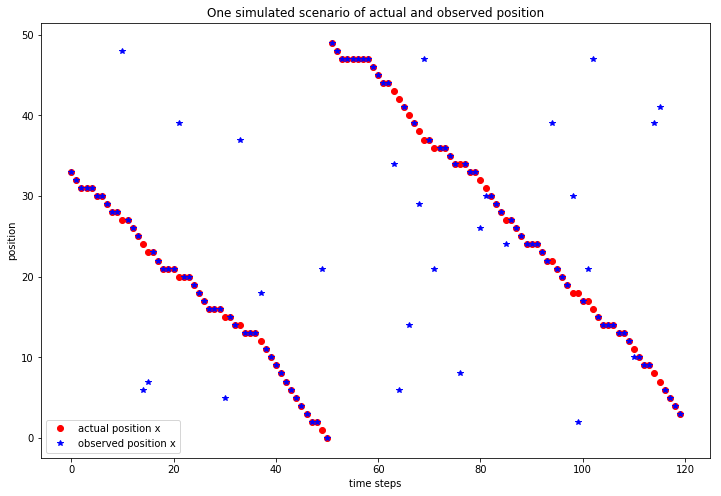

In [164]:
def sample_loc (prob, prob_distrbution): 
    # return the idx loction of prob in the prob_distrbution
    nr_loc = len(prob_distrbution)
    cum_sum = np.cumsum(prob_distrbution)  
    idx = np.where(prob < cum_sum)[0]  
    return idx[0]


# simulator the trajectory 
for ti in np.arange(0,nr_ts):   
    for si in np.arange(0, nr_sc): 
        if ti == 0: # the initial position is uniformly distributed among the N positions with 1/N probablity
            xs[si,ti] = randint(0, N)      
        else: # pi > 0
            x_ti_prob = tran_model[:,xs[si,ti-1]]
            rand_prob = np.random.uniform(0,1)  
            idx_loc = sample_loc(rand_prob, x_ti_prob) 
            xs[si, ti] = idx_loc 
        y_ti_prob = obs_model[:,xs[si,ti]]
        rand_prob = np.random.uniform(0,1)  
        idx_loc = sample_loc(rand_prob, y_ti_prob) 
        ys[si,ti] = idx_loc
        
si = 5
timesteps = np.arange(0,nr_ts)
plt.figure(figsize=(12, 8))
plt.plot(timesteps, xs[si, :],'ro', label="actual position x")  
plt.plot(timesteps, ys[si, :], 'b*', label="observed position x")  
plt.xlabel('time steps')
plt.ylabel('position')
plt.legend()
plt.title('One simulated scenario of actual and observed position')
plt.show()        


### Q1.5. 
Implement the Forward-Backward algorithm for computing the quantities defined in 3-a,b,f. (Attention: be
careful with numerical stability! Modify the log-sum-exp trick for this algorithm)
        
        
            

In [166]:
def predict(tran_model, lp):
    # STATE_PREDICT, compute tran_model * prob in the log domain
    
    # input 
    # tran_model: State transition matrix
    # lp : log p(x_{k-1}, y_{1:k-1}) Filtered potential
    
    # output: 
    # lpp : log p(x_{k}, y_{1:k-1}); Predicted potential
    
    lstar = np.max(lp)
    return lstar + np.log(np.dot(A,np.exp(lp-lstar)))


def postdict(tran_model, lp):
    # input 
    # tran_model: State transition matrix
    # lp : log p(x_{k-1}, y_{1:k-1}) Filtered potential
    
    lstar = np.max(lp)
    return lstar + np.log(np.dot(np.exp(lp-lstar), tran_model))


def update(y, logB, lp):
    
    # Inputs :
    # obs : p(y_k| x_k)
    # y  : the postion of y
    # lp: log_p : log p(x_k, y_{1, k-1})
    
    # Outputs : 
    #     lup : log p(x_k, y_{1, k-1}) p(y_k| x_k)
      
    return logB[y,:] + lp

(a) Distribution of the robot’s current position given the observations so far, i.e. the filtering distribution: 

$$\large p(x_k | y_{1:k}) = \frac{p(x_k,  y_{1:k})}{p(y_{1:k})} = \frac{\alpha_{k|k}(x_k)}{\sum_{x_k}p(x_k, y_{1:k})} = \frac{\alpha_{k|k}(x_k)}{\sum_{x_k}\alpha_{k|k}(x_k)}$$


In [191]:
# Forward Pass
# alpha_1_0 = p(x_1)
# alpha_1_1 = p(y_1|x_1)p(x_1) = p(y_1|x_1) alpha_1_0
alpha_1_0 = np.ones((N, 1)) / N 
alpha_1_1 = obs_model.dot(alpha_1_0)

# Python indices start from zero so
# log \alpha_{k|k} will be in log_alpha[:,k-1]
# log \alpha_{k|k-1} will be in log_alpha_pred[:,k-1]

x = xs[si, :]
y = ys[si, :]
p = alpha_1_0.copy()
A = tran_model.copy()
B = obs_model.copy()

logA = np.log(A)
logB = np.log(B)

# N: number of states/positions
# nr_ts: number of time steps
log_alpha  = np.zeros((N, nr_ts))
log_alpha_pred = np.zeros((N, nr_ts))

for ti in np.arange(nr_ts):
    if ti==0:
        log_alpha_pred[:,0] = np.log(p)[0]
    else:
        log_alpha_pred[:,ti] = predict(A, log_alpha[:,ti-1])
    
    log_alpha[:,ti] = update(y[ti], logB, log_alpha_pred[:,ti])  
    

# Backward Pass
log_beta  = np.zeros((N, nr_ts))
log_beta_post = np.zeros((N, nr_ts))

backward_range = np.arange(nr_ts - 1, -1, -1)
for ti in backward_range:
    if ti == nr_ts - 1:
        log_beta_post[:,ti] = np.zeros(N)
    else:
        log_beta_post[:,ti] = postdict(A, log_beta[:,ti+1])
    log_beta[:,ti] = update(y[ti], logB, log_beta_post[:,ti])  


In [194]:
# Smoother check
# All numbers must be equal to the marginal likelihood p(y_{1:K})

log_gamma = log_alpha + log_beta_post
print(stable_logsumexp(log_gamma))



-228.50108064295685


In [184]:
                          
range(nr_ts-1,-1,-1),
np.arange(nr_ts-1,-1,-1)

array([119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107,
       106, 105, 104, 103, 102, 101, 100,  99,  98,  97,  96,  95,  94,
        93,  92,  91,  90,  89,  88,  87,  86,  85,  84,  83,  82,  81,
        80,  79,  78,  77,  76,  75,  74,  73,  72,  71,  70,  69,  68,
        67,  66,  65,  64,  63,  62,  61,  60,  59,  58,  57,  56,  55,
        54,  53,  52,  51,  50,  49,  48,  47,  46,  45,  44,  43,  42,
        41,  40,  39,  38,  37,  36,  35,  34,  33,  32,  31,  30,  29,
        28,  27,  26,  25,  24,  23,  22,  21,  20,  19,  18,  17,  16,
        15,  14,  13,  12,  11,  10,   9,   8,   7,   6,   5,   4,   3,
         2,   1,   0])

In [ ]:
# (a) Distribution of the robot’s current position given the observations so far

In [143]:
alpha_1_0 = np.ones((N, 1)) / N 
alpha_1_1 = obs_model.dot(alpha_1_0)

print (alpha_1_0.T , alpha_1_1.T)

[[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
  0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
  0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
  0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]] [[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
  0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
  0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
  0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]]


In [ ]:
# (b) Distribution of the robot’s position at time step k given all the observations

In [ ]:
# (f) Most likely current position of the robot given the observations so far

In [ ]:
print (xs, '\n', ys)


idx_loc = sample_loc(rand_prob, y_pi_prob) 

print (xpi_, rand_prob, y_pi_prob, idx_loc)

In [ ]:
#f = X(find(rand<cumsum(P),1,'first'))

p_dis = obs_model[:,3]
xi = np.random.uniform(0, 1)
cum_sum = np.cumsum(p_dis)

xi = 



idx = np.where(xi < cum_sum)

print (cum_sum, xi, idx[0][0])

In [25]:

N = 50 
i = 49
j = np.mod(i- 1 +N,N)
j,


(48,)

In [20]:
%timeit np.sum(np.arange(100))
x0 = np.arange(100)
print (x0)

2.66 µs ± 38.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [ ]:
# An implementation of the forward backward algorithm
# For numerical stability, we calculate everything in the log domain

def normalize_exp(log_P, axis=None):
    a = np.max(log_P, keepdims=True, axis=axis)
    P = normalize(np.exp(log_P - a), axis=axis)
    return P


def normalize(A, axis=None):
    Z = np.sum(A, axis=axis,keepdims=True)
    idx = np.where(Z == 0)
    Z[idx] = 1
    return A/Z

def randgen(pr, N=1): 
    L = len(pr)
    return np.random.choice(range(L), size=N, replace=True, p=pr)

def predict(A, lp):
    lstar = np.max(lp)
    return lstar + np.log(np.dot(A,np.exp(lp-lstar)))


def postdict(A, lp):
    lstar = np.max(lp)
    return lstar + np.log(np.dot(np.exp(lp-lstar), A))

def update(y, logB, lp):
    return logB[y,:] + lp

In [ ]:

Break:

\begin{eqnarray}
p(y_{1:K}|x^*_{1:K}) & = & \max_{x_{1:K}} p(y_{1:K}|x_{1:K}) p(x_{1:K}) \\
& = &  \underbrace{\max_{x_K} L(y_T | x_K ) +\max_{x_{K-1}} L(x_K|x_{K-1})}_{\alpha_K}  \dots +\max_{x_{2}} L(x_3|x_{2})
                               \underbrace{L(y_{2}|x_{2})\overbrace{ +\max_{x_{1}} L(x_2|x_{1})}^{\alpha_{2|1}} }_{\alpha_2}
                                 \underbrace{L(y_{1}|x_{1})+\overbrace{L(x_1)}^{\alpha_{1|0}}}_{\alpha_1}
\end{eqnarray}

\begin{eqnarray}
p(y_{1:K}|x^*_{1:K})  =   \max_{x_1} p(x_1) p(y_1 | x_1 )
%underbrace{\max_{x_2} p(x_2|x_{1}) p(y_2 | x_2 )}_{\beta_1}
\dots
\underbrace{ \max_{x_{K-1}} p(x_{K-1}|x_{K-2}) p(y_{K-1} | x_{K-1} )}_{\beta_{K-2}}
\underbrace{ \max_{x_K} p(x_K|x_{K-1}) p(y_K | x_K )}_{\beta_{K-1}}
\underbrace{{\pmb 1}}_{\beta_{K}}
\end{eqnarray}



p(y_{1:k}|x^*_{1:k})  =   \max_{x_1} p(x_1) p(y_1 | x_1 )
%underbrace{\max_{x_2} p(x_2|x_{1}) p(y_2 | x_2 )}_{\beta_1}
\dots
\underbrace{ \max_{x_{k-1}} p(x_{k-1}|x_{k-2}) p(y_{k-1} | x_{k-1} )}_{\beta_{k-2}}
\underbrace{ \max_{x_k} p(x_k|x_{k-1}) p(y_k | x_k )}_{\beta_{k-1}}
\underbrace{{\pmb 1}}_{\beta_{k}}


In [ ]:
(d) Distribution of the robot’s next sensor reading given the observations so far

\begin{eqnarray}
p(y_{1:K}) & = & \sum_{x_{1:K}} p(y_{1:K}|x_{1:K}) p(x_{1:K}) \\
& = &  \underbrace{\sum_{x_K} p(y_K | x_K ) \sum_{x_{K-1}} p(x_K|x_{K-1})  \dots \sum_{x_{2}} p(x_3|x_{2})
\underbrace{ p(y_{2}|x_{2}) \overbrace{ \sum_{x_{1}} p(x_2|x_{1})
\underbrace{ p(y_{1}|x_{1}) \overbrace{ p(x_1)}^{\alpha_{1|0}}}_{\alpha_{1|1}}
}^{\alpha_{2|1}} }_{\alpha_{2|2}}}_{\alpha_{K|K}}
\end{eqnarray}

\begin{eqnarray}
p(y_{1:K}) & = & \sum_{x_{1:K}} p(y_{1:K}|x_{1:K}) p(x_{1:K}) \\
& = &  \underbrace{\sum_{x_K} p(y_K | x_K ) \sum_{x_{K-1}} p(x_K|x_{K-1})  \dots \sum_{x_{2}} p(x_3|x_{2})
\underbrace{ p(y_{2}|x_{2}) \overbrace{ \sum_{x_{1}} p(x_2|x_{1})
\underbrace{ p(y_{1}|x_{1}) \overbrace{ p(x_1)}^{\alpha_{1|0}}}_{\alpha_{1|1}}
}^{\alpha_{2|1}} }_{\alpha_{2|2}}}_{\alpha_{K|K}}
\end{eqnarray}

In [ ]:
&= \sum_{x_{k+1}}p(y_{k+1}|x_{k+1})\sum_{x_k}p(x_{k+1}|x_{k})\alpha_{k|k}(x_k)}

In [ ]:
\begin{align}
 p(x_k , y_{1:K}) &= p(x_k, y_{1:k}, y_{k+1:K}) = p(x_k, y_{1:k})* p(y_{k+1:K}|(x_k, y_{1:k}) \\
   &= p(x_k, y_{1:k})* p(y_{k+1:K}|(x_k) =  \alpha_{k|k}(x_k) * \beta_{k|k+1}(x_k) 
\end{align}



%\begin{equation*}
$$
\large p(x_k , y_{1:K}) &= p(x_k, y_{1:k}, y_{k+1:K}) = p(x_k, y_{1:k})* p(y_{k+1:K}|(x_k, y_{1:k}) \\
   &= p(x_k, y_{1:k})* p(y_{k+1:K}|(x_k) =  \alpha_{k|k}(x_k) * \beta_{k|k+1}(x_k)   
$$   
%\end{equation*}


....
....









{\tiny
    \begin{align}
        a &< b
    \end{align}
}

In [ ]:
\begin{equation}% 
\mbox{\Large\( %
f(y) = a \cdot k^{y} %
\)} %
\end{equation}

In [ ]:
class LogReg(object):
    """A class for the logistic regression with L2 penalization"""

    def __init__(self, X, y, lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda
    
    def grad(self, w):        
        return 1./ self.n * (- self.y.T.dot(self.X)) / (1 + np.exp(self.y.T.dot(self.X).dot(w))) + self.lbda * w

    def f(self, w):
        bAx = self.y * np.dot(self.X, w)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(w) ** 2 / 2.
    
    def f_i(self,i, w):
        bAx_i = self.y[i] * np.dot(self.X[i], w)
        return np.log(1. + np.exp(- bAx_i)) + self.lbda * norm(w) ** 2 / 2.
    
    def grad_i(self, i, w):
        # calculate the gradient of f_i 
        return - self.y[i] * self.X[i,:] / (1 + np.exp(self.y[i] * self.X[i,:].dot(w))) + self.lbda * w

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = norm(self.X, ord=2) ** 2  / (4. * self.n) + self.lbda
        return L
    
    
    

In [ ]:
$p(x_{k+1}|x_k=i)= \Bigg[ \begin{array}{cc}
0 & 1  \\
... & 2 \\
... & ... \\
1 - \epsilon & j \\
\epsilon & i \\
... & ... \\

0 & N  \end{array}\Bigg]$


$\bigg[ \begin{array}{c}
a  \\
b \end{array} \bigg]$
$=\Bigg[ \begin{array}{c}
y_1   \\
...  \\
y_n  \end{array} \Bigg]$

This is break

$p(x_{k+1}|x_k=i)= \Bigg[ \begin{array}{cc}
 0  & 1  \\
... & 2  \\
... & ... \\
1 - \epsilon & j \\
\epsilon & i \\
... & ... \\
0 & N \end{array} \Bigg]$


In [46]:
$\Rightarrow\Bigg[ \begin{array}{cc}
x_1 & 1  \\
... & 1 \\
x_n & 1  \end{array} \Bigg]$
$\bigg[ \begin{array}{c}
a  \\
b \end{array} \bigg]$
$=\Bigg[ \begin{array}{c}
y_1   \\
...  \\
y_n  \end{array} \Bigg]$



This to break
$$\begin{pmatrix}a & b\\\ c & d\end{pmatrix}$$

This to break

$p(x_{k+1}|x_k=i)= \Bigg\{ \begin{array}{cc}
 0   \\
...  \\
1 - \epsilon  \\
\epsilon  \\
...  \\
0 \end{array}
\Bigg\} \Bigg[\begin{array}{cc} 
 1   \\
...  \\
j \\
i  \\
...  \\
N 
\end{array} \Bigg] $




SyntaxError: invalid syntax (<ipython-input-46-0a391cb2d658>, line 1)

In [ ]:
var1 = input("Enter a: ")
var2 = input("Enter b: ")
exponent = input("Enter n: ")

a = int(var1)
b = int(var2)
n = int(exponent)

expression = ('%(1)dx^%(2)d') %{'1' : a, '2' : n}

print(expression)

In [ ]:
#titlestr = 'Directed Graphical model, with','$x_i$'', ' the actual position', $y_i$, 'the observed position'
#"meters $10^1$"

titlestr = "Directed Graphical model, with " + "$x_i$" + " the actual position and $y_i$ the observed position"
titlestr,

x1 = r'$\alpha_i > \beta_i$'
x1,

r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$'

x1 = r"$s(t) = \mathcal{A}\mathrm{sin}(2 \omega t)$"
print (x1)

#x1 =  'Here is a {} floating point number'.format(3.33333)'
x1 = ('(%(1)s%(2)d)^%(3)d') %\
{'1' : 'x', '2' : 2, '3' : 6}


print(x1)

In [ ]:
#x1 = ('%(1)s%^%(2)d') %{'1' : 'x',  '2' : 6}
from sympy import pretty_print as pp, latex
#x1 = ('%(1)s_%(2)d') %{'1' : 'x',  '2' : 6}
#x2 = latex("$x_i$")

#x2 = x\N{SUPERSCRIPT THREE}


x2 = f'\N{GREEK SMALL LETTER GAMMA}={density:.2f} t/m\N{SUPERSCRIPT THREE}'
print (x2)
#print(latex(x2))
#print(x2)

In [ ]:
(d) Distribution of the robot’s next sensor reading given the observations so far

$$\large
\begin{align*}
p(y_{k+1}|y_{1:k}) &= \frac{p(y_{k+1},y_{1:k})}{p(y_{1:k})} =  p(y_{k+1},y_{1:k}) = p(y_{1:k+1}) \\
    &= \sum_{x_1, x_2, \ ...,\ x_{k+1}} p(y_{1:k+1}, x_{1:k+1}) \\
    &= \sum_{x_1, x_2, \ ...,\ x_{k+1}}p(x_1)p(y_1|x_1)\pi_{n=2}^{k+1}p(x_n|x_{n-1})p(y_n|x_n) \\
    &= \sum_{x_1, x_2, \ ...,\ x_{k+1}}p(y_{k+1}|x_{k+1})p(x_k|x_{k+1})  ...p(y_{2}|x_{2})p(x_2|x_{1})p(y_{1}|x_{1})p(x_{1}) \\
    &= \sum_{x_{k+1}}p(y_{k+1}|x_{k+1})\sum_{x_k}p(x_{k+1}|x_{k})p(y_k|x_k)...  \sum_{x_2}p(x_{3}|x_{2})p(y_2|x_2)\sum_{x_1}p(x_{2}|x_{1})p(y_1|x_1)p(x_1)  \\
    &= \sum_{x_{k+1}}p(y_{k+1}|x_{k+1}) \sum_{x_k}p(x_{k+1}|x_{k})\alpha_{k|k}(x_k)
\end{align*}
$$

## Please review this part!

In [ ]:

Where
$$\large
\begin{align*}
p(y_{1:k}|x^*_{1:k}) & = \max_{x_{1:k}} p(y_{1:k},x_{1:k}) p(x_{1:k}) \\
& =  \underbrace{\max_{x_k} L(y_T | x_k ) +\max_{x_{k-1}} L(x_k|x_{k-1})}_{\alpha_k}  \dots +\max_{x_{2}} \underbrace{L(y_{2}|x_{2})\overbrace{ +\max_{x_{1}} L(x_2|x_{1})}^{\alpha_{2|1}} }_{\alpha_2}
\underbrace{L(y_{1}|x_{1})+\overbrace{L(x_1)}^{\alpha_{1|0}}}_{\alpha_1} \\
\end{align*}
$$

Then
$$\large
\begin{align*}
p(y_{1:k}|x^*_{1:k})  & =   \max_{x_1} p(x_1) p(y_1 | x_1 )
%underbrace{\max_{x_2} p(x_2|x_{1}) p(y_2 | x_2 )}_{\beta_1}
\dots
\underbrace{ \max_{x_{k-1}} p(x_{k-1}|x_{k-2}) p(y_{k-1} | x_{k-1} )}_{\beta_{k-2}}
\underbrace{ \max_{x_k} p(x_k|x_{k-1}) p(y_k | x_k )}_{\beta_{k-1}}
\underbrace{{\pmb 1}}_{\beta_{k}}
\end{align*}
$$


The derivation depends on the following decomposition. By the chain rule of probabilities, we write
\begin{eqnarray}
p(x_{1:t}|y_{1:t}) & = & p(x_{1}|x_{2:t}, y_{1:t}) \cdots p(x_{t-2}|x_{t-1:t}, y_{1:t}) p(x_{t-1}|x_t, y_{1:t}) p(x_{t}|y_{1:t}) 
\end{eqnarray}
The key observation is that this expression admits computation in the forward direction. By conditional independence
\begin{eqnarray}
p(x_{1:t}|y_{1:t}) & = & p(x_{1}|x_{2}, y_{1}) \cdots p(x_{t-2}|x_{t-1}, y_{1:t-2}) p(x_{t-1}|x_t, y_{1:t-1}) p(x_{t}|y_{1:t}) 
\end{eqnarray}


In [ ]:

test2


$$\large
\begin{align*}
x_{1:k}^* &= arg \max_{x_{1:k}}p(x_{1:k}|y_{1:k}) \\
 & = \arg\max_{x_{1:k}} \frac{p(y_{1:k}|x_{1:k}) p(x_{1:k})}{p(y_{1:k})} \\
 & = \arg\max_{x_{1:k}} \log p(y_{1:k}|x_{1:k}) + \log p(x_{1:k}) - \log p(y_{1:k}) 
\end{align*}
$$
TEST

$$\large
\begin{align*}
x_{1:k}^* &= arg \max_{x_{1:k}}p(x_{1:k}|y_{1:k}) \\
&= arg \max_{x_{1:k}} p(x_{1}|x_{2:t}, y_{1:t}) \cdots p(x_{t-2}|x_{t-1:t}, y_{1:t}) p(x_{t-1}|x_t, y_{1:t}) p(x_{t}|y_{1:t}) \\
\underbrace{arg \max_{x_{1:k}} p(x_{1}|x_{2:t}, y_{1:t}) \cdots p(x_{t-2}|x_{t-1:t}, y_{1:t}) p(x_{t-1}|x_t, y_{1:t}) p(x_{t}|y_{1:t})}_{By conditional independence}
& = arg \max_{x_{1:k}} p(x_{1}|x_{2}, y_{1}) \cdots p(x_{t-2}|x_{t-1}, y_{1:t-2}) p(x_{t-1}|x_t, y_{1:t-1}) p(x_{t}|y_{1:t}) 
\end{align*}
$$




Where
$$\large
\begin{align*}
p(y_{1:k}|x^*_{1:k}) & = \max_{x_{1:k}} p(y_{1:k},x_{1:k}) p(x_{1:k}) 
\end{align*}
$$

Then
$$\large
\begin{align*}
p(y_{1:k}|x^*_{1:k})  & =   \max_{x_1} p(x_1) p(y_1 | x_1 )
%underbrace{\max_{x_2} p(x_2|x_{1}) p(y_2 | x_2 )}_{\beta_1}
\dots
\underbrace{ \max_{x_{k-1}} p(x_{k-1}|x_{k-2}) p(y_{k-1} | x_{k-1} )}_{\beta_{k-2}}
\underbrace{ \max_{x_k} p(x_k|x_{k-1}) p(y_k | x_k )}_{\beta_{k-1}}
\underbrace{{\pmb 1}}_{\beta_{k}}
\end{align*}
$$


The derivation depends on the following decomposition. By the chain rule of probabilities, we write
\begin{eqnarray}
p(x_{1:t}|y_{1:t}) & = & p(x_{1}|x_{2:t}, y_{1:t}) \cdots p(x_{t-2}|x_{t-1:t}, y_{1:t}) p(x_{t-1}|x_t, y_{1:t}) p(x_{t}|y_{1:t}) 
\end{eqnarray}
The key observation is that this expression admits computation in the forward direction. By conditional independence
\begin{eqnarray}
p(x_{1:t}|y_{1:t}) & = & p(x_{1}|x_{2}, y_{1}) \cdots p(x_{t-2}|x_{t-1}, y_{1:t-2}) p(x_{t-1}|x_t, y_{1:t-1}) p(x_{t}|y_{1:t}) 
\end{eqnarray}
